In [ ]:

#%pip install tensorflow

import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


%matplotlib inline  
# %matplotlib inline, Jupyter Notebook gibi interaktif ortamlarda kullanılan bir "magic" komutudur. Bu komut, matplotlib grafiklerinin notebook hücresinin altında doğrudan görüntülenmesini sağlar; yani grafikler ayrı bir pencere açılmadan notebook içinde yer alır.

plt.style.use('ggplot')

print(os.listdir(".")) #Bu kod ayni dizindeki dosyalari listeler. iki nokta ust dizini listeler

DIR = os.listdir('./chest_xray/chest_xray')  

print(DIR)  

['main.ipynb', '.DS_Store', 'chest_xray', 'cnn_model.keras', 'lung_300.jpg', 'README.md', '.git']
['test', 'train', 'val']


In [5]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    data=[]
    for label in labels:
#         train/PNEUMONIA
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) 

In [6]:

train = "./chest_xray/chest_xray/train"
test = "./chest_xray/chest_xray/test"
val = "./chest_xray/chest_xray/val"


In [7]:
pneumonia = os.listdir("./chest_xray/chest_xray/train/PNEUMONIA")
penomina_dir = "./chest_xray/chest_xray/train/PNEUMONIA"

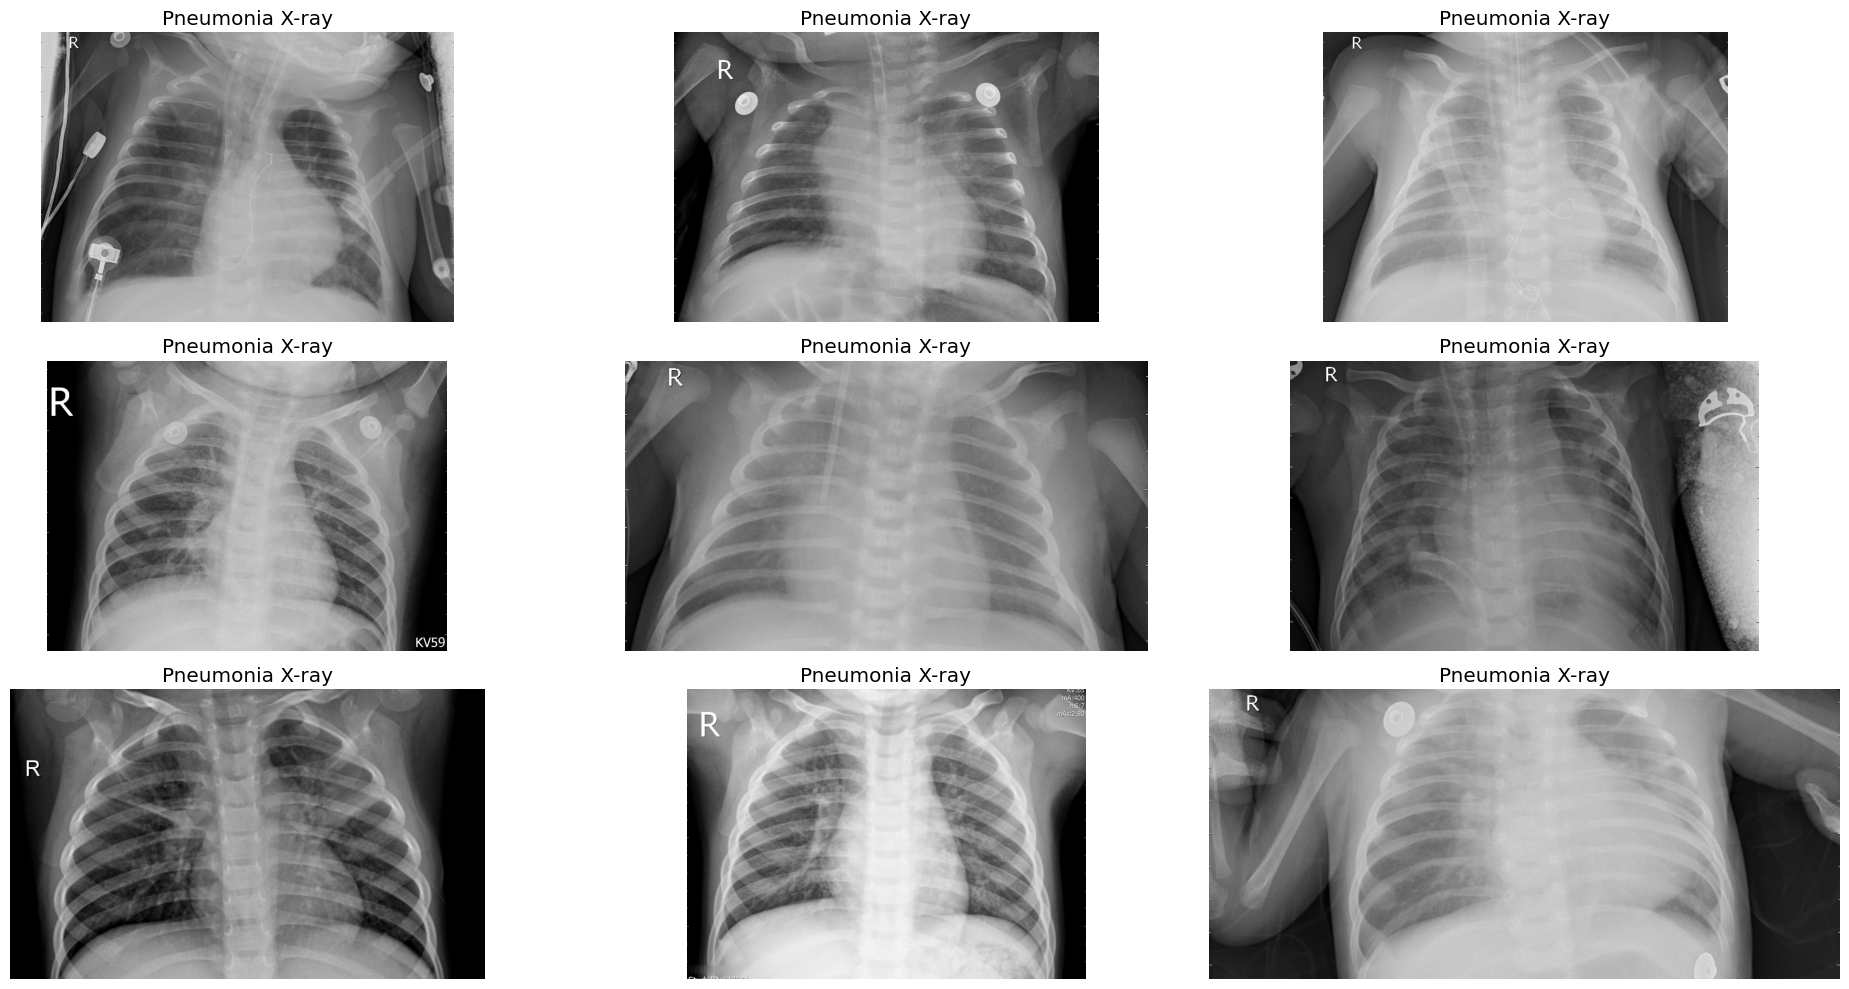

In [8]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [9]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

BATCH_SIZE = 32

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_data = train_datagen.flow_from_directory(
    train,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    color_mode='grayscale' 
)

val_data = train_datagen.flow_from_directory(
    val,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    color_mode='grayscale' 
)

test_data = train_datagen.flow_from_directory(
    test,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    color_mode='grayscale' 
)
print(train_data.class_indices) #siniflarin adlarini yazdirir

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [12]:
first_model=Sequential()
first_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))) #sondaki 1 renksiz resim oldugu icin. Renkli olsaydi 3 olacakti
first_model.add(MaxPool2D(2,2))
first_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
first_model.add(MaxPool2D(2,2))
first_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
first_model.add(MaxPool2D(2,2))
first_model.add(Flatten())
first_model.add(Dense(256, activation='relu'))
first_model.add(Dense(128, activation='relu'))
first_model.add(Dense(1, activation='sigmoid')) # Eger 2 den fazla class varsa softmax kullanilir

first_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,548,481 (24.98 MB)

 Trainable params: 6,548,481 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# compile model
first_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=['accuracy'])

Model Egitme

In [14]:
history = first_model.fit(train_data,
                          epochs=15,
                          verbose=1,
                          validation_data=val_data
                          )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.7664 - loss: 0.4707 - val_accuracy: 0.8125 - val_loss: 0.4271
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - accuracy: 0.9277 - loss: 0.1792 - val_accuracy: 0.7500 - val_loss: 0.4946
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.9354 - loss: 0.1626 - val_accuracy: 0.6250 - val_loss: 0.8984
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.9523 - loss: 0.1208 - val_accuracy: 0.9375 - val_loss: 0.3574
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.9506 - loss: 0.1226 - val_accuracy: 0.8125 - val_loss: 0.4813
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.9444 - loss: 0.1350 - val_accuracy: 0.7500 - val_loss: 0.4772
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.9581 - loss: 0.1097 - val_accuracy: 0.9375 - val_loss: 0.2104
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 271ms/step - accuracy: 0.9602 - loss: 0

In [18]:
loss, accuracy = first_model.evaluate(test_data)
print("Test Accuracy = %f  ;  loss = %f " % (accuracy, loss))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7624 - loss: 1.2075
Test Accuracy = 0.754808  ;  loss = 1.202118 


In [ ]:
import numpy as np

# Test verilerinin predict fonksiyonu ile tahmin edilmesi
predictions = first_model.predict(test_data)

# En yüksek olasılığa sahip sınıf etiketlerini alma
predicted_classes = np.argmax(predictions, axis=1)

# İlk 15 tahmini gösterme
print(predicted_classes[:15])


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Looding the Model

In [ ]:

first_model.save("cnn_model.keras")

In [ ]:
labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Görüntüyü gri tonlamada oku
    new_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))  # Boyutu 128x128'e yeniden boyutlandır
    return new_array.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)  # Modelin girdi formatına uygun hale getir


In [ ]:
# extra pneumonia photo from google
prediction = first_model.predict([prepare("lung_300.jpg")])
print(labels[int(prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
PNEUMONIA


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 128, 128, 1))',)
  warnings.warn(msg)
/var/folders/rl/_d7g0j2d1_d7lbp6jk84l7xh0000gn/T/ipykernel_56912/1379170344.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(labels[int(prediction[0])])
